### $\bullet\;Import\;Libraries$

In [109]:
%pip install torchmetrics
%pip install torchview

Note: you may need to restart the kernel to use updated packages.


In [110]:
import torch
import torch.nn             as nn
import torch.optim          as optim
import torch.nn.functional  as F
import torch.backends.cudnn as cudnn
import torchvision
import matplotlib.pyplot    as plt
import numpy                as np
import pandas               as pd
import os
import pickle

from torch.utils.data       import TensorDataset, DataLoader, random_split
from torchvision            import transforms
from torchvision.datasets   import CIFAR10
from torchmetrics           import Accuracy
from tqdm                   import tqdm
from torch.utils.data       import Dataset
from PIL                    import Image
from math                   import sqrt

from torchview import draw_graph
from IPython.display import Image, display

plt.style.use('grayscale')

### $\bullet\;CIFAR\;Dataset$

#### $Load\;Dataset$

In [134]:
dataset = CIFAR10(root='./cifar10', train=True, download=True, transform=transforms.ToTensor())

loader = DataLoader(dataset, batch_size=len(dataset), shuffle=False, num_workers=2)
data_iter = iter(loader)
images, _ = next(data_iter) 

mean = images.mean(dim=[0, 2, 3])
std = images.std(dim=[0, 2, 3])

print("Mean per channel :", mean)
print("Std per channel  :", std)

Files already downloaded and verified
Mean per channel : tensor([0.4914, 0.4822, 0.4465])
Std per channel  : tensor([0.2470, 0.2435, 0.2616])


In [111]:
transform   = transforms.Compose([transforms.ToTensor(), transforms.Normalize(mean=[0.4914, 0.4822, 0.4465], std=[0.2470, 0.2435, 0.2616])])

train_set   = CIFAR10(root='./cifar10', train=True , download=True, transform=transform)
test_set    = CIFAR10(root='./cifar10', train=False, download=True, transform=transform)

100%|██████████| 170M/170M [00:01<00:00, 104MB/s]  


Extracting ./cifar10/cifar-10-python.tar.gz to ./cifar10
Files already downloaded and verified


#### $Train\;set-Test\;set\;Classes$

In [112]:
pd.DataFrame(train_set.class_to_idx.items(), columns=['Class Name', 'Class Index']).style.hide()

Class Name,Class Index
airplane,0
automobile,1
bird,2
cat,3
deer,4
dog,5
frog,6
horse,7
ship,8
truck,9


In [113]:
pd.DataFrame(train_set.class_to_idx.items(), columns=['Class Name', 'Class Index']).style.hide()

Class Name,Class Index
airplane,0
automobile,1
bird,2
cat,3
deer,4
dog,5
frog,6
horse,7
ship,8
truck,9


In [114]:
class AverageMeter(object):
    """Computes and stores the average and current value"""
    def __init__(self):
        self.reset()

    def reset(self):
        self.val    = 0
        self.avg    = 0
        self.sum    = 0
        self.count  = 0

    def update(self, val, n=1):
        self.val    = val
        self.sum    += val * n
        self.count  += n
        self.avg    = self.sum / self.count

### $\bullet\;$ CIFAR10 DataLoader, Visualization

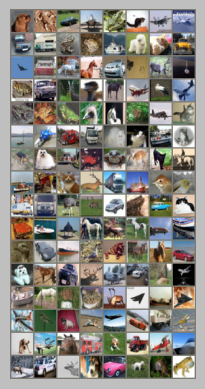

In [115]:
# DataLoader
trainloader = torch.utils.data.DataLoader(train_set, batch_size=128, shuffle=True, num_workers=4)
testloader = torch.utils.data.DataLoader(test_set, batch_size=256, shuffle=False, num_workers=4)

def denormalize(img, mean, std):
    mean = torch.tensor(mean).view(3, 1, 1)
    std = torch.tensor(std).view(3, 1, 1)
    return img * std + mean

# Show one batch of images
dataiter = iter(trainloader)
images, labels = next(dataiter)
img_grid = torchvision.utils.make_grid(images)
img_grid = denormalize(img_grid, mean, std)
plt.imshow(img_grid.permute(1, 2, 0).clamp(0, 1))
plt.axis('off')
plt.show()

### $\bullet\;$ CNN Model

model size: 38021440 bit | 4.75 MB


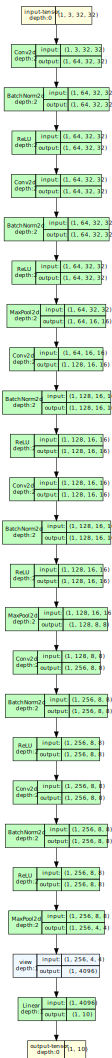

In [130]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        # 7 layers total: 6 conv + final classifier
        self.features = nn.Sequential(
            # Block 1
            nn.Conv2d(3, 64, 3, padding=1), nn.BatchNorm2d(64), nn.ReLU(),
            nn.Conv2d(64, 64, 3, padding=1), nn.BatchNorm2d(64), nn.ReLU(), nn.MaxPool2d(2),
            # Block 2
            nn.Conv2d(64, 128, 3, padding=1), nn.BatchNorm2d(128), nn.ReLU(),
            nn.Conv2d(128, 128, 3, padding=1), nn.BatchNorm2d(128), nn.ReLU(), nn.MaxPool2d(2),
            # Block 3
            nn.Conv2d(128, 256, 3, padding=1), nn.BatchNorm2d(256), nn.ReLU(),
            nn.Conv2d(256, 256, 3, padding=1), nn.BatchNorm2d(256), nn.ReLU(), nn.MaxPool2d(2)
        )
        self.classifier = nn.Linear(256 * 4 * 4, 10)

    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)
        x = self.classifier(x)
        return x

model = CNN()
batch_size = 2
size_model = 0
for param in model.parameters():
    if param.data.is_floating_point():
        size_model += param.numel() * torch.finfo(param.data.dtype).bits
    else:
        size_model += param.numel() * torch.iinfo(param.data.dtype).bits
print(f"model size: {size_model} bit | {size_model / 8e6:.2f} MB")

model_graph = draw_graph(model, input_size=(1, 3, 32, 32), device='meta')
display(model_graph.visual_graph)

In [135]:
def print_layer_outputs(model, input_size):
    x = torch.randn(input_size)
    print(f"Input: {x.shape}")
    count = 0
    for i, layer in enumerate(model.features):
        x = layer(x)
        if layer.__class__.__name__ in ['Conv2d']:
            count += 1
        print(f"Layer {count} ({layer.__class__.__name__}): {x.shape}")
    x = x.view(x.size(0), -1)
    print(f"Flatten: {x.shape}")
    x = model.classifier(x)
    print(f"Classifier Output: {x.shape}")

model = CNN().to('cpu')
print_layer_outputs(model, (1, 3, 32, 32))

Input: torch.Size([1, 3, 32, 32])
Layer 1 (Conv2d): torch.Size([1, 64, 32, 32])
Layer 1 (BatchNorm2d): torch.Size([1, 64, 32, 32])
Layer 1 (ReLU): torch.Size([1, 64, 32, 32])
Layer 2 (Conv2d): torch.Size([1, 64, 32, 32])
Layer 2 (BatchNorm2d): torch.Size([1, 64, 32, 32])
Layer 2 (ReLU): torch.Size([1, 64, 32, 32])
Layer 2 (MaxPool2d): torch.Size([1, 64, 16, 16])
Layer 3 (Conv2d): torch.Size([1, 128, 16, 16])
Layer 3 (BatchNorm2d): torch.Size([1, 128, 16, 16])
Layer 3 (ReLU): torch.Size([1, 128, 16, 16])
Layer 4 (Conv2d): torch.Size([1, 128, 16, 16])
Layer 4 (BatchNorm2d): torch.Size([1, 128, 16, 16])
Layer 4 (ReLU): torch.Size([1, 128, 16, 16])
Layer 4 (MaxPool2d): torch.Size([1, 128, 8, 8])
Layer 5 (Conv2d): torch.Size([1, 256, 8, 8])
Layer 5 (BatchNorm2d): torch.Size([1, 256, 8, 8])
Layer 5 (ReLU): torch.Size([1, 256, 8, 8])
Layer 6 (Conv2d): torch.Size([1, 256, 8, 8])
Layer 6 (BatchNorm2d): torch.Size([1, 256, 8, 8])
Layer 6 (ReLU): torch.Size([1, 256, 8, 8])
Layer 6 (MaxPool2d): to

### $\bullet\;$ Train

#### loss, optimizer, scheduler

using CrossEntropyLoss

using Adam with lr=0.001, weight_decay=1e-4

In [125]:
# Select device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = CNN().to(device)

# loss, optimizer, scheduler
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(), lr=0.001, weight_decay=1e-4)
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=25)

In [126]:
# Training loop with loss tracking
epochs = 20
train_accs, test_accs, train_losses, test_losses = [], [], [], []
for epoch in range(1, epochs+1):
    model.train()
    correct, total = 0, 0
    running_loss = 0.0
    for i, (inputs, targets) in enumerate(trainloader, 1):
        inputs, targets = inputs.to(device), targets.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()
        _, preds = outputs.max(1)
        total += targets.size(0)
        correct += preds.eq(targets).sum().item()
        running_loss += loss.item() * inputs.size(0)
    train_accs.append(100.*correct/total)
    train_losses.append(running_loss / total)

    model.eval()
    correct, total = 0, 0
    running_loss = 0.0
    with torch.no_grad():
        for inputs, targets in testloader:
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            _, preds = outputs.max(1)
            total += targets.size(0)
            correct += preds.eq(targets).sum().item()
            loss = criterion(outputs, targets)
            running_loss += loss.item() * inputs.size(0)
    test_acc = 100. * correct / total
    test_losses.append(running_loss / total)
    test_accs.append(test_acc)
    scheduler.step()
    print(f"Epoch {epoch:2d}: Train Acc = {train_accs[-1]:.2f}%, Test Acc = {test_acc:.2f}%")

Epoch  1: Train Acc = 55.35%, Test Acc = 68.04%
Epoch  2: Train Acc = 74.67%, Test Acc = 69.61%
Epoch  3: Train Acc = 80.95%, Test Acc = 79.66%
Epoch  4: Train Acc = 85.12%, Test Acc = 80.01%
Epoch  5: Train Acc = 88.78%, Test Acc = 80.91%
Epoch  6: Train Acc = 91.52%, Test Acc = 82.27%
Epoch  7: Train Acc = 94.16%, Test Acc = 82.62%
Epoch  8: Train Acc = 96.70%, Test Acc = 81.66%
Epoch  9: Train Acc = 97.99%, Test Acc = 84.58%
Epoch 10: Train Acc = 99.04%, Test Acc = 85.31%
Epoch 11: Train Acc = 99.86%, Test Acc = 86.45%
Epoch 12: Train Acc = 99.94%, Test Acc = 86.89%
Epoch 13: Train Acc = 100.00%, Test Acc = 87.15%
Epoch 14: Train Acc = 100.00%, Test Acc = 87.51%
Epoch 15: Train Acc = 100.00%, Test Acc = 87.65%
Epoch 16: Train Acc = 100.00%, Test Acc = 87.60%
Epoch 17: Train Acc = 100.00%, Test Acc = 87.73%
Epoch 18: Train Acc = 100.00%, Test Acc = 87.71%
Epoch 19: Train Acc = 100.00%, Test Acc = 87.74%
Epoch 20: Train Acc = 100.00%, Test Acc = 87.68%


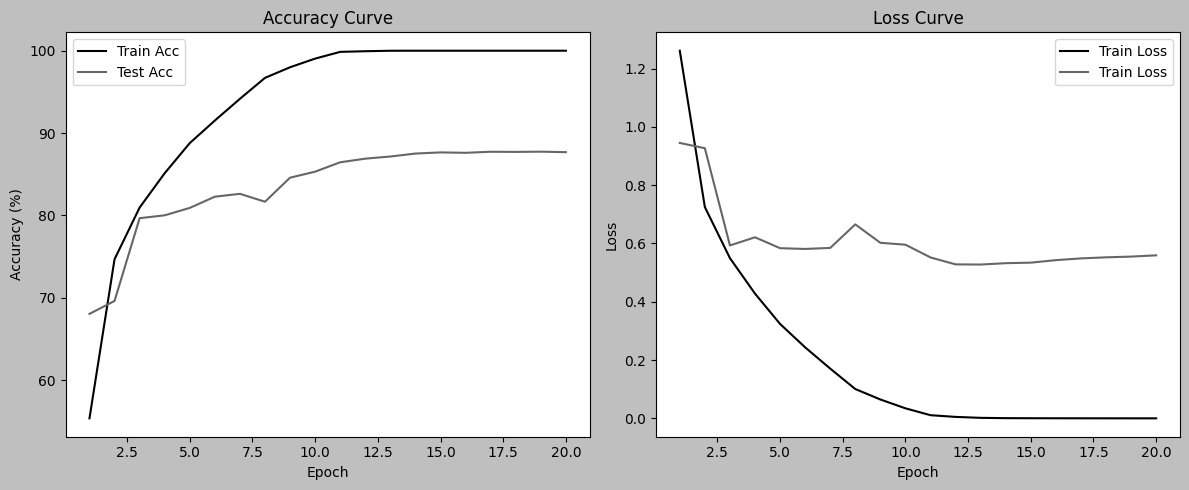

In [127]:
# Plot accuracy and loss curves
eps = range(1, epochs+1)
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(eps, train_accs, label='Train Acc')
plt.plot(eps, test_accs, label='Test Acc')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.legend()
plt.title('Accuracy Curve')

plt.subplot(1,2,2)
plt.plot(eps, train_losses, label='Train Loss')
plt.plot(eps, test_losses, label='Train Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Loss Curve')

plt.tight_layout()
plt.show()